# Heart Disease Prediction Using Spark

## Import Data

In [171]:
# Must be included at the beginning of each new notebook.
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('heart').getOrCreate()

In [172]:
# Let's read in the data. Note that it's in the format of CSV.
df = spark.read.csv('Datasets/heart.csv',inferSchema=True, header=True)
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- sex: integer (nullable = true)
 |-- cp: integer (nullable = true)
 |-- trestbps: integer (nullable = true)
 |-- chol: integer (nullable = true)
 |-- fbs: integer (nullable = true)
 |-- restecg: integer (nullable = true)
 |-- thalach: integer (nullable = true)
 |-- exang: integer (nullable = true)
 |-- oldpeak: double (nullable = true)
 |-- slope: integer (nullable = true)
 |-- ca: integer (nullable = true)
 |-- thal: integer (nullable = true)
 |-- target: integer (nullable = true)



In [173]:
# Let's get a better look at the data.
# We know that we can show a DataFrame, but that's resulted in a mess! 
df.show()

+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
|age|sex| cp|trestbps|chol|fbs|restecg|thalach|exang|oldpeak|slope| ca|thal|target|
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
| 63|  1|  3|     145| 233|  1|      0|    150|    0|    2.3|    0|  0|   1|     1|
| 37|  1|  2|     130| 250|  0|      1|    187|    0|    3.5|    0|  0|   2|     1|
| 41|  0|  1|     130| 204|  0|      0|    172|    0|    1.4|    2|  0|   2|     1|
| 56|  1|  1|     120| 236|  0|      1|    178|    0|    0.8|    2|  0|   2|     1|
| 57|  0|  0|     120| 354|  0|      1|    163|    1|    0.6|    2|  0|   2|     1|
| 57|  1|  0|     140| 192|  0|      1|    148|    0|    0.4|    1|  0|   1|     1|
| 56|  0|  1|     140| 294|  0|      0|    153|    0|    1.3|    1|  0|   2|     1|
| 44|  1|  1|     120| 263|  0|      1|    173|    0|    0.0|    2|  0|   3|     1|
| 52|  1|  2|     172| 199|  1|      1|    162|    0|    0.5|    2|  0|   3|

In [174]:
# Instead, let's just grab the first row. Much neater! 
df.head(1)

[Row(age=63, sex=1, cp=3, trestbps=145, chol=233, fbs=1, restecg=0, thalach=150, exang=0, oldpeak=2.3, slope=0, ca=0, thal=1, target=1)]

In [175]:
print((df.count(), len(df.columns)))

(303, 14)


## Data Exploration

### Distribution of Patient Age

In [176]:
df.agg({"age":"mean"}).show()

+------------------+
|          avg(age)|
+------------------+
|54.366336633663366|
+------------------+



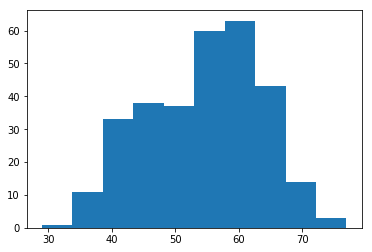

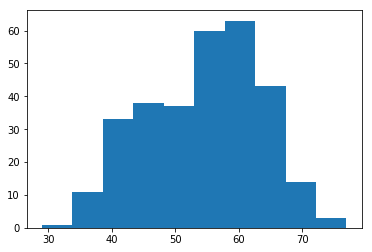

In [177]:
# Import the relevant Python libraries.
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Convert age to an array using Numpy and plot it using pyplot. 
ageArr = np.array(df.select('age').collect())
plt.hist(ageArr)
plt.show()

# Because you can interact with Spark using SQL, you can also filter the data you see. 
# For example, age has some null values. We can remove all null values before visualising the data.
ageArr = np.array(df.filter('Age > 0').select('Age').collect())
plt.hist(ageArr)
plt.show()

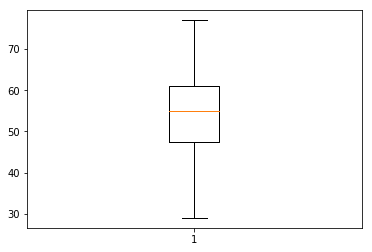

In [178]:
plt.boxplot(ageArr)
plt.show()

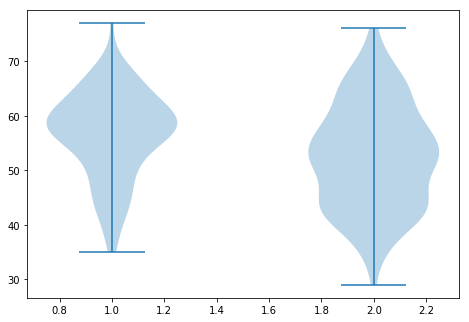

In [179]:
df.createOrReplaceTempView('heart')

age0 = spark.sql("SELECT age FROM heart WHERE target = 0")
age0Arr = np.array(age0.collect())
age1 = spark.sql("SELECT age FROM heart WHERE target = 1")
age1Arr = np.array(age1.collect())

## combine these different collections into a list
data_to_plot = [age0Arr, age1Arr]

# Create a figure instance
fig = plt.figure()

# Create an axes instance
ax = fig.add_axes([0,0,1,1])

# Create the boxplot
bp = ax.violinplot(data_to_plot)
plt.show()

In [180]:
import pandas as pd

In [181]:
from tabulate import tabulate as tabulate
def violin_stats(x,y,sparkdf):
    df0 = sparkdf.toPandas()
    df1 = df0.loc[df0[x] == 0] #the blue violin
    df2 = df0.loc[df0[x] == 1] #the orange violin

    interval = 0.95
    start = (1-interval)/2*100
    end = 100-start
    
    value1 = round(np.percentile(df1[y], start),2)
    value2 = round(np.percentile(df1[y], end),2)
    std1 = round(np.std(df1[y]),4)
    skew1 = round(df1[y].skew(),2)
    mean1 = round(np.mean(df1[y]),2)
    min1 = round(np.min(df1[y]),2)
    max1 = round(np.max(df1[y]),2)
    median1 = round(np.median(df1[y]),2)
    value_1 = round(np.percentile(df2[y], start),2)
    value_2 = round(np.percentile(df2[y], end),2)
    std2 = round(np.std(df2[y]),2)
    skew2 = round(df2[y].skew(),2)
    mean2 = round(np.mean(df2[y]),2)
    min2 = round(np.min(df2[y]),2)
    max2 = round(np.max(df2[y]),2)
    median2 = round(np.median(df2[y]),2)
    print(tabulate([['0',(value1,value2),std1,skew1,mean1,min1,max1,median1], ['1',(value_1,value_2),std2,skew2,mean2,min2,max2,median2]], headers=['target', '95% interval','Standard deviation','Skewness','Mean','Min','Max','Median']))

In [182]:
violin_stats('target','age',df)

  target  95% interval      Standard deviation    Skewness    Mean    Min    Max    Median
--------  --------------  --------------------  ----------  ------  -----  -----  --------
       0  (39.43, 69.57)                7.9332       -0.55    56.6     35     77        58
       1  (35.2, 70.9)                  9.52          0.12    52.5     29     76        52


### Distribution of Resting Blood Pressure

In [183]:
df.agg({"trestbps":"mean"}).show()

+------------------+
|     avg(trestbps)|
+------------------+
|131.62376237623764|
+------------------+



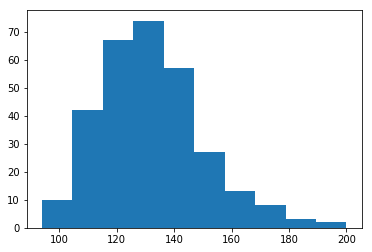

In [184]:
tbpsArr = np.array(df.filter('trestbps > 0').select('trestbps').collect())
plt.hist(tbpsArr)
plt.show()

In [185]:
import seaborn as sns

In [186]:
pddf = df.toPandas()

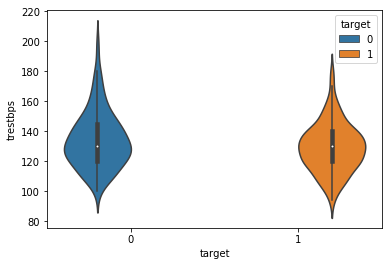

In [187]:
sns.violinplot(x="target",y="trestbps", hue="target", data=pddf);
plt.show()

In [188]:
violin_stats('target','trestbps',df)

  target  95% interval        Standard deviation    Skewness    Mean    Min    Max    Median
--------  ----------------  --------------------  ----------  ------  -----  -----  --------
       0  (108.85, 179.15)                18.662        0.86   134.4    100    200       130
       1  (101.1, 160.0)                  16.12         0.42   129.3     94    180       130


### Distribution of Cholesterol Levels

In [189]:
df.agg({"chol":"mean"}).show()

+------------------+
|         avg(chol)|
+------------------+
|246.26402640264027|
+------------------+



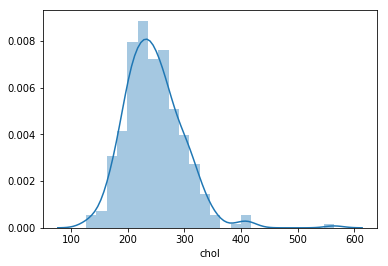

In [190]:
chol = pddf['chol']
sns.distplot(chol)

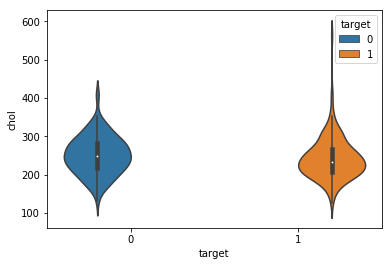

In [191]:
sns.violinplot(x="target",y="chol", hue="target", data=pddf);
plt.show()

In [192]:
violin_stats('target','chol',df)

  target  95% interval        Standard deviation    Skewness    Mean    Min    Max    Median
--------  ----------------  --------------------  ----------  ------  -----  -----  --------
       0  (166.42, 338.45)               49.2751        0.32  251.09    131    409       249
       1  (160.8, 352.8)                 53.39          1.75  242.23    126    564       234


### Distribution of Maximum Heart Rate

In [193]:
df.agg({"thalach":"mean"}).show()

+------------------+
|      avg(thalach)|
+------------------+
|149.64686468646866|
+------------------+



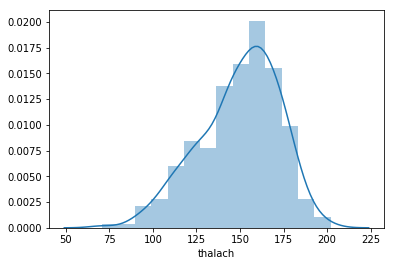

In [194]:
thalach = pddf['thalach']
sns.distplot(thalach)

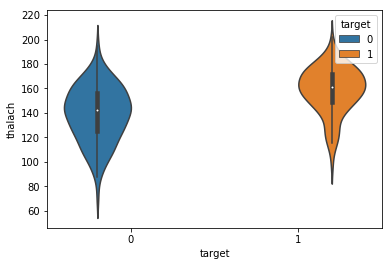

In [195]:
sns.violinplot(x="target",y="thalach", hue="target", data=pddf);
plt.show()

In [196]:
violin_stats('target','thalach',df)

  target  95% interval       Standard deviation    Skewness    Mean    Min    Max    Median
--------  ---------------  --------------------  ----------  ------  -----  -----  --------
       0  (95.43, 175.72)               22.5168       -0.3   139.1      71    195       142
       1  (115.0, 187.9)                19.12         -0.71  158.47     96    202       161


### Exercise Induced ST Depression

In [197]:
df.agg({"oldpeak":"mean"}).show()

+------------------+
|      avg(oldpeak)|
+------------------+
|1.0396039603960396|
+------------------+



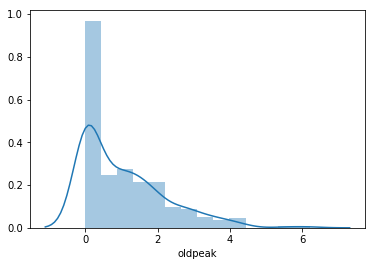

In [198]:
oldpeak = pddf['oldpeak'];
sns.distplot(oldpeak)

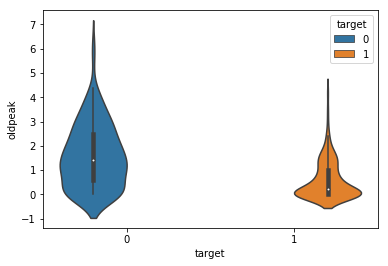

In [199]:
sns.violinplot(x="target",y="oldpeak", hue="target", data=pddf);
plt.show()

In [200]:
violin_stats('target','oldpeak',df)

  target  95% interval      Standard deviation    Skewness    Mean    Min    Max    Median
--------  --------------  --------------------  ----------  ------  -----  -----  --------
       0  (0.0, 4.11)                   1.2956        0.74    1.59      0    6.2       1.4
       1  (0.0, 2.39)                   0.78          1.65    0.58      0    4.2       0.2


### Gender

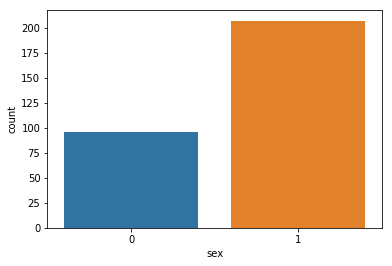

In [201]:
sns.countplot(x='sex',data=pddf)

### Chest Pain

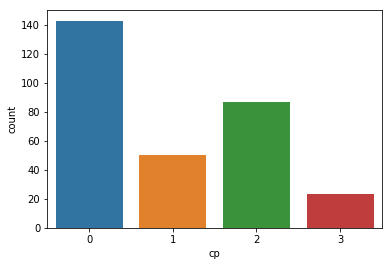

In [202]:
sns.countplot(x='cp',data=pddf)

### Fasting Blood Sugar

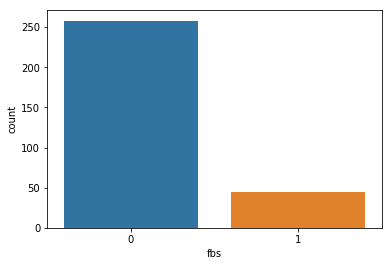

In [203]:
sns.countplot(x='fbs',data=pddf)

### Resting ECG Results

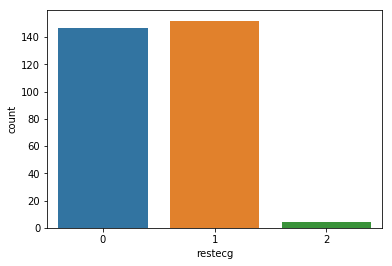

In [204]:
sns.countplot(x='restecg',data=pddf)

### Exercise Induced Angina

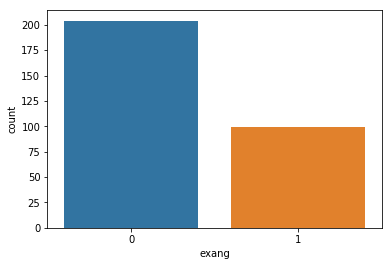

In [205]:
sns.countplot(x='exang',data=pddf)

### Peak Exercise ST segment

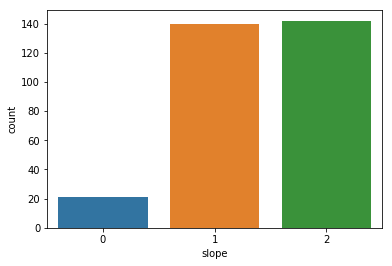

In [206]:
sns.countplot(x='slope',data=pddf)

### β-Thalassemia Cardiomyopathy

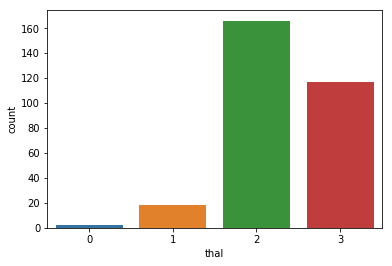

In [207]:
sns.countplot(x='thal',data=pddf)

## More Aggregation

In [208]:
df.groupBy('target').mean().show()

+------+-----------------+------------------+------------------+-----------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+-----------+
|target|         avg(age)|          avg(sex)|           avg(cp)|    avg(trestbps)|         avg(chol)|           avg(fbs)|      avg(restecg)|      avg(thalach)|        avg(exang)|      avg(oldpeak)|        avg(slope)|            avg(ca)|         avg(thal)|avg(target)|
+------+-----------------+------------------+------------------+-----------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+-----------+
|     1| 52.4969696969697|0.5636363636363636|1.3757575757575757|129.3030303030303|242.23030303030302| 0.1393939393939394| 0.593939393939394|158.46666666666667|0.1393939393939394|0.5830303030303029

In [209]:
df.groupBy('sex').mean().select(['sex','avg(age)']).show()

+---+------------------+
|sex|          avg(age)|
+---+------------------+
|  1| 53.75845410628019|
|  0|55.677083333333336|
+---+------------------+



In [210]:
df.groupBy('target').min().select(['target','min(age)']).show()

+------+--------+
|target|min(age)|
+------+--------+
|     1|      29|
|     0|      35|
+------+--------+



## More Spark DataFrame Operations

In [211]:
df.corr('age','trestbps')

0.27935090656128797

In [212]:
df.cov('age','trestbps')

44.49590190807155

In [213]:
df.cov('age','fbs')

0.3924332830634057

In [214]:
df.cov('age','chol')

100.58507638843362

In [215]:
df.describe(['age']).show()

+-------+------------------+
|summary|               age|
+-------+------------------+
|  count|               303|
|   mean|54.366336633663366|
| stddev|  9.08210098983786|
|    min|                29|
|    max|                77|
+-------+------------------+



In [216]:
df.filter("age > 60").where("sex = 0").where("target = 1").sort(df.age.asc()).collect()

[Row(age=62, sex=0, cp=0, trestbps=124, chol=209, fbs=0, restecg=1, thalach=163, exang=0, oldpeak=0.0, slope=2, ca=0, thal=2, target=1),
 Row(age=62, sex=0, cp=0, trestbps=140, chol=394, fbs=0, restecg=0, thalach=157, exang=0, oldpeak=1.2, slope=1, ca=0, thal=2, target=1),
 Row(age=63, sex=0, cp=2, trestbps=135, chol=252, fbs=0, restecg=0, thalach=172, exang=0, oldpeak=0.0, slope=2, ca=0, thal=2, target=1),
 Row(age=63, sex=0, cp=1, trestbps=140, chol=195, fbs=0, restecg=1, thalach=179, exang=0, oldpeak=0.0, slope=2, ca=2, thal=2, target=1),
 Row(age=64, sex=0, cp=0, trestbps=180, chol=325, fbs=0, restecg=1, thalach=154, exang=1, oldpeak=0.0, slope=2, ca=0, thal=2, target=1),
 Row(age=64, sex=0, cp=2, trestbps=140, chol=313, fbs=0, restecg=1, thalach=133, exang=0, oldpeak=0.2, slope=2, ca=0, thal=3, target=1),
 Row(age=64, sex=0, cp=0, trestbps=130, chol=303, fbs=0, restecg=1, thalach=122, exang=0, oldpeak=2.0, slope=1, ca=2, thal=2, target=1),
 Row(age=65, sex=0, cp=2, trestbps=140, c

In [217]:
from pyspark.sql import functions as F
df.select(df.age, F.when(df.age > 60, 1).when(df.age < 40, -1).otherwise(0)).show()

+---+--------------------------------------------------------------+
|age|CASE WHEN (age > 60) THEN 1 WHEN (age < 40) THEN -1 ELSE 0 END|
+---+--------------------------------------------------------------+
| 63|                                                             1|
| 37|                                                            -1|
| 41|                                                             0|
| 56|                                                             0|
| 57|                                                             0|
| 57|                                                             0|
| 56|                                                             0|
| 44|                                                             0|
| 52|                                                             0|
| 57|                                                             0|
| 54|                                                             0|
| 48|                             

### Eliminate outliers

In [218]:
pddf1 = pddf.filter(['age','trestbps','chol','thalach','oldpeak'], axis=1)

In [219]:
pddf1.shape

(303, 5)

In [220]:
from scipy import stats
z = np.abs(stats.zscore(pddf1))
pddf2 = pddf1[(z < 3).all(axis=1)]

In [221]:
pddf2.shape

(294, 5)

In [222]:
pd.concat([pddf1,pddf2]).drop_duplicates(keep=False)

,age,trestbps,chol,thalach,oldpeak
28,65,140,417,157,0.8
85,67,115,564,160,1.6
204,62,160,164,145,6.2
220,63,150,407,154,4.0
221,55,140,217,111,5.6
223,56,200,288,133,4.0
246,56,134,409,150,1.9
248,54,192,283,195,0.0
272,67,120,237,71,1.0


**We may NOT drop outliers only because one of the continuous column not satisfy normal distribution** (still use pddf)

### Correlation Matrix

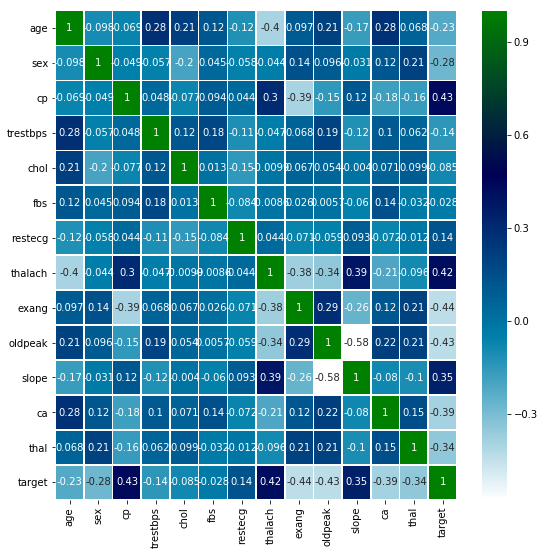

In [223]:
plt.figure(figsize=(9, 9))
sns.heatmap(pddf.corr(),linewidths=0.6,annot=True,cmap='ocean_r',cbar=True)

## Data Preparation

**The data exploration phase may use Pandas dataframe as well, while from this part mainly use Spark Dataframe.**

### Data Clean

In [224]:
df.na.drop().show()

+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
|age|sex| cp|trestbps|chol|fbs|restecg|thalach|exang|oldpeak|slope| ca|thal|target|
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
| 63|  1|  3|     145| 233|  1|      0|    150|    0|    2.3|    0|  0|   1|     1|
| 37|  1|  2|     130| 250|  0|      1|    187|    0|    3.5|    0|  0|   2|     1|
| 41|  0|  1|     130| 204|  0|      0|    172|    0|    1.4|    2|  0|   2|     1|
| 56|  1|  1|     120| 236|  0|      1|    178|    0|    0.8|    2|  0|   2|     1|
| 57|  0|  0|     120| 354|  0|      1|    163|    1|    0.6|    2|  0|   2|     1|
| 57|  1|  0|     140| 192|  0|      1|    148|    0|    0.4|    1|  0|   1|     1|
| 56|  0|  1|     140| 294|  0|      0|    153|    0|    1.3|    1|  0|   2|     1|
| 44|  1|  1|     120| 263|  0|      1|    173|    0|    0.0|    2|  0|   3|     1|
| 52|  1|  2|     172| 199|  1|      1|    162|    0|    0.5|    2|  0|   3|

In [225]:
def anyNull(df):
    df.createOrReplaceTempView('heart')
    for col in df.columns:
        spark.sql("SELECT * FROM heart WHERE "+col+"= null").show()

In [226]:
anyNull(df)

+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
|age|sex| cp|trestbps|chol|fbs|restecg|thalach|exang|oldpeak|slope| ca|thal|target|
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+

+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
|age|sex| cp|trestbps|chol|fbs|restecg|thalach|exang|oldpeak|slope| ca|thal|target|
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+

+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
|age|sex| cp|trestbps|chol|fbs|restecg|thalach|exang|oldpeak|slope| ca|thal|target|
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+---

### Data Construct

#### Change numeric to categorical data

In [227]:
df.printSchema()

def categorize(df):
    columns = ['sex','cp','fbs','ca','restecg','exang','restecg','slope','thal']
    for col in columns:
        df.withColumn(col, df[col].cast("category"))
    df.printSchema

root
 |-- age: integer (nullable = true)
 |-- sex: integer (nullable = true)
 |-- cp: integer (nullable = true)
 |-- trestbps: integer (nullable = true)
 |-- chol: integer (nullable = true)
 |-- fbs: integer (nullable = true)
 |-- restecg: integer (nullable = true)
 |-- thalach: integer (nullable = true)
 |-- exang: integer (nullable = true)
 |-- oldpeak: double (nullable = true)
 |-- slope: integer (nullable = true)
 |-- ca: integer (nullable = true)
 |-- thal: integer (nullable = true)
 |-- target: integer (nullable = true)



In [228]:
#change numeric to categorical
from pyspark.ml.feature import (VectorAssembler,VectorIndexer,
                                OneHotEncoder,StringIndexer)

In [229]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer

indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df) for column in list(['sex','cp','fbs','ca','exang','restecg','slope','thal']) ]

pipeline = Pipeline(stages=indexers)
df_r = pipeline.fit(df).transform(df)

df_r.select(['sex','sex_index','cp','cp_index','fbs','fbs_index','ca','ca_index','exang','exang_index','restecg','restecg_index','slope','slope_index','thal','thal_index',]).show()

+---+---------+---+--------+---+---------+---+--------+-----+-----------+-------+-------------+-----+-----------+----+----------+
|sex|sex_index| cp|cp_index|fbs|fbs_index| ca|ca_index|exang|exang_index|restecg|restecg_index|slope|slope_index|thal|thal_index|
+---+---------+---+--------+---+---------+---+--------+-----+-----------+-------+-------------+-----+-----------+----+----------+
|  1|      0.0|  3|     3.0|  1|      1.0|  0|     0.0|    0|        0.0|      0|          1.0|    0|        2.0|   1|       2.0|
|  1|      0.0|  2|     1.0|  0|      0.0|  0|     0.0|    0|        0.0|      1|          0.0|    0|        2.0|   2|       0.0|
|  0|      1.0|  1|     2.0|  0|      0.0|  0|     0.0|    0|        0.0|      0|          1.0|    2|        0.0|   2|       0.0|
|  1|      0.0|  1|     2.0|  0|      0.0|  0|     0.0|    0|        0.0|      1|          0.0|    2|        0.0|   2|       0.0|
|  0|      1.0|  0|     0.0|  0|      0.0|  0|     0.0|    1|        1.0|      1|         

## Data Transformation

### Reduce Data

In [230]:
# Now we can assemble all of this as one vector in the features column. 
inputCols = list(set(df.columns)-set(['target']))
print(inputCols)
assembler = VectorAssembler(inputCols=inputCols,outputCol='features')

['restecg', 'thalach', 'chol', 'ca', 'trestbps', 'oldpeak', 'age', 'sex', 'thal', 'fbs', 'exang', 'cp', 'slope']


**Notice the sequences of input factors in assembler is different from the original dataframe.**

In [231]:
from pyspark.ml.classification import RandomForestClassifier
from numpy import allclose
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StringIndexer

td = assembler.transform(df)
rf = RandomForestClassifier(numTrees=3, maxDepth=2, labelCol="target", seed=42)
model = rf.fit(td)
print(model.featureImportances)

from pyspark.ml.feature import ChiSqSelector
selector = ChiSqSelector(numTopFeatures=13, featuresCol="features",
                         outputCol="selectedFeatures", labelCol="target")

result = selector.fit(td).transform(td)

print("ChiSqSelector output with top %d features selected" % selector.getNumTopFeatures())

selector.fit(td).selectedFeatures

(13,[3,5,6,11,12],[0.18063345214309914,0.418600336857637,0.027472667785522903,0.31839333760194677,0.05490020561179412])
ChiSqSelector output with top 13 features selected


[8, 11, 3, 10, 12, 7, 5, 0, 1, 2, 6, 4, 9]

**Combine the 2 results, the RFT selector select: [age, thal, thalach, ca, cp, exang] (basically categorical data); while the chisqselector: [thal, cp, ca, exang, slope, sex, oldpeak, restecg, thalach, chol, age, trestbps, fbs] (But chisqselector mainly for selecting categorical data.)**

**We may drop: fbs**

In [232]:
df1 = df.drop('fbs')

In [233]:
print((df1.count(), len(df1.columns)))

(303, 13)


### Rebalancing Data

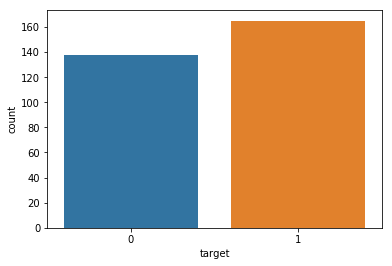

In [234]:
sns.countplot(x='target',data=df1.toPandas())

In [235]:
import sklearn
from sklearn.utils import resample

In [236]:
# Separate majority and minority classes
pddf1 = df1.toPandas()
df_majority = pddf1[pddf1.target==1]
df_minority = pddf1[pddf1.target==0]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=df_majority.shape[0],    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.target.value_counts()

1    165
0    165
Name: target, dtype: int64

In [237]:
df_upsampled.shape

(330, 13)

## Statistical Transformation

In [238]:
def stats_trans(df):
    columns = ['age','trestbps','chol','thalach','oldpeak']
    for col in columns:
        df[col] = np.log(df[col])
        #or: df_upsampled[['chol_log','thalach_log']]=df_new[['chol','thalach']].apply(lambda x : np.log(x))

In [239]:
df_log = df_upsampled.copy() #initialize the new dataframe (log transformed)
stats_trans(df_log)

/home/ubuntu/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


In [240]:
col_dict = {'age':'log_age','trestbps':'log_trestbps',
                      'chol':'log_chol','thalach':'log_thalach','oldpeak':'log_oldpeak'}   ## key→old name, value→new name

df_log.columns = [col_dict.get(x, x) for x in df_log.columns]
df_log.rename(columns={}, inplace=True)

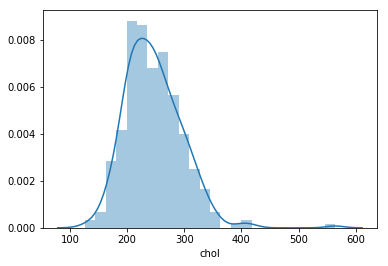

In [241]:
sns.distplot(df_upsampled.chol)

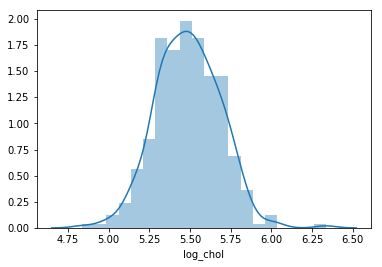

In [242]:
sns.distplot(df_log.log_chol)

In [243]:
df_log.head()

,log_age,sex,cp,log_trestbps,log_chol,restecg,log_thalach,exang,log_oldpeak,slope,ca,thal,target
0,4.143135,1,3,4.976734,5.451038,0,5.010635,0,0.832909,0,0,1,1
1,3.610918,1,2,4.867534,5.521461,1,5.231109,0,1.252763,0,0,2,1
2,3.713572,0,1,4.867534,5.318120,0,5.147494,0,0.336472,2,0,2,1
3,4.025352,1,1,4.787492,5.463832,1,5.181784,0,-0.223144,2,0,2,1
4,4.043051,0,0,4.787492,5.869297,1,5.093750,1,-0.510826,2,0,2,1


## Data Mining

**Now we use the transformed spark dataframe df1 for data mining.**

### Split Data

In [244]:
inputCols = list(set(df1.columns)-set(['target']))
assembler2 = VectorAssembler(inputCols=inputCols,outputCol='features')

In [245]:
# Train/test split. 
train_data, test_data = df1.randomSplit([0.8,.2])

### Functions

In [246]:
from pyspark.ml import Pipeline

In [247]:
def datamining(model):
    pipeline = Pipeline(stages=[assembler2, model])
    fit_model = pipeline.fit(train_data)
    results = fit_model.transform(test_data)
    from pyspark.ml.evaluation import BinaryClassificationEvaluator
    my_eval = BinaryClassificationEvaluator(rawPredictionCol='prediction',
                                       labelCol='target')
    results.select('target','prediction').show()
    # We can then evaluate using AUC (area under the curve). AUC is linked to ROC.
    AUC = my_eval.evaluate(results)
    print("AUC is: ",AUC)
    # Let's import the evaluator.
    from pyspark.ml.evaluation import MulticlassClassificationEvaluator
    # Select (prediction, true label) and compute test error. 
    acc_evaluator = MulticlassClassificationEvaluator(labelCol="target", predictionCol="prediction", metricName="accuracy")
    acc = acc_evaluator.evaluate(results)
    # Let's do something a bit more complex in terms of printing, just so it's formatted nicer. 
    print("Here are the results!")
    print('-'*40)
    print('Accuracy: {0:2.2f}%'.format(acc*100))


### Train the model

#### Logistic Regression (model1)

In [248]:
from pyspark.ml.classification import LogisticRegression

In [249]:
# Note that target is a categorial variable but didn't require any transformation.
# That's because it's already in the format of 1's and 0's. 
log_reg_heart = LogisticRegression(featuresCol='features',labelCol='target')

In [250]:
# Lists everything we want to do. Index data, encode data, assemble data and then pass in the actual model.
pipeline = Pipeline(stages=[assembler2,log_reg_heart])

In [251]:
# Note pipeline. Call it as you would call a machine learning object.
fit_model1 = pipeline.fit(train_data)

In [252]:
# Transform test data. 
results1 = fit_model1.transform(test_data)

In [253]:
# Evaluate the model using the binary classifer.
from pyspark.ml.evaluation import BinaryClassificationEvaluator

my_eval1 = BinaryClassificationEvaluator(rawPredictionCol='prediction',
                                       labelCol='target')

In [254]:
# If we select the actual and predicted results, we can see that some predictions were correct while others were wrong.
results1.select('target','prediction').show()

+------+----------+
|target|prediction|
+------+----------+
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     0|       0.0|
|     0|       0.0|
|     1|       1.0|
|     0|       0.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       0.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
+------+----------+
only showing top 20 rows



In [255]:
# We can then evaluate using AUC (area under the curve). AUC is linked to ROC.
AUC = my_eval1.evaluate(results1)

AUC

0.8142857142857143

**3 Types of Tree Models**

In [256]:
from pyspark.ml.classification import DecisionTreeClassifier,GBTClassifier,RandomForestClassifier

In [257]:
# Use defaults to make the comparison "fair". This simplifies the comparison process.

dtc = DecisionTreeClassifier(labelCol='target',featuresCol='features')
rfc = RandomForestClassifier(labelCol='target',featuresCol='features')
gbt = GBTClassifier(labelCol='target',featuresCol='features')

#### Decision Tree (model2)

In [258]:
datamining(dtc)

+------+----------+
|target|prediction|
+------+----------+
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     0|       0.0|
|     0|       0.0|
|     1|       0.0|
|     0|       0.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
+------+----------+
only showing top 20 rows

AUC is:  0.7517857142857143
Here are the results!
----------------------------------------
Accuracy: 76.47%


#### Random Forest Trees (model3)

In [259]:
datamining(rfc)

+------+----------+
|target|prediction|
+------+----------+
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     0|       0.0|
|     0|       0.0|
|     1|       1.0|
|     0|       0.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       0.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
+------+----------+
only showing top 20 rows

AUC is:  0.8017857142857143
Here are the results!
----------------------------------------
Accuracy: 82.35%


#### GBT (model4)

In [260]:
datamining(gbt)

+------+----------+
|target|prediction|
+------+----------+
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     0|       0.0|
|     0|       0.0|
|     1|       0.0|
|     0|       0.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
+------+----------+
only showing top 20 rows

AUC is:  0.7517857142857143
Here are the results!
----------------------------------------
Accuracy: 76.47%


#### Naive Bayes (model5)

In [261]:
from pyspark.ml.classification import NaiveBayes

In [262]:
nb = NaiveBayes(smoothing=1.0, modelType="multinomial",labelCol='target',featuresCol='features')

In [263]:
datamining(nb)

+------+----------+
|target|prediction|
+------+----------+
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       0.0|
|     1|       1.0|
|     1|       1.0|
|     0|       0.0|
|     0|       0.0|
|     1|       1.0|
|     0|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       0.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
+------+----------+
only showing top 20 rows

AUC is:  0.7160714285714287
Here are the results!
----------------------------------------
Accuracy: 73.53%


#### Multilayer Perceptron (model6)

In [264]:
from pyspark.ml.classification import MultilayerPerceptronClassifier

In [265]:
# specify layers for the neural network:
# input layer of size 12 (features), two intermediate of size 13 and 12
# and output of size 2 (classes)
layers = [12, 13, 12, 2]
mlp = MultilayerPerceptronClassifier(maxIter=100, layers=layers, blockSize=128, seed=1234, labelCol='target',featuresCol='features')

In [266]:
datamining(mlp)

+------+----------+
|target|prediction|
+------+----------+
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     0|       0.0|
|     0|       0.0|
|     1|       1.0|
|     0|       0.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       0.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
+------+----------+
only showing top 20 rows

AUC is:  0.8196428571428571
Here are the results!
----------------------------------------
Accuracy: 83.82%


### Parameter Tuning 

In [267]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [268]:
paramGrid = ParamGridBuilder() \
    .addGrid(log_reg_heart.regParam, [0.1, 0.01]) \
    .addGrid(log_reg_heart.maxIter, [10, 100, 1000]) \
    .build()

In [269]:
from pyspark.ml.evaluation import RegressionEvaluator

In [270]:
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit

In [271]:
# Prepare training and test data.
train, test = df1.randomSplit([0.8, 0.2], seed=12345)

# lr = LogisticRegression(maxIter=10)

# We use a ParamGridBuilder to construct a grid of parameters to search over.
# TrainValidationSplit will try all combinations of values and determine best model using
# the evaluator.
paramGrid = ParamGridBuilder()\
    .addGrid(log_reg_heart.regParam, [0.1, 0.01]) \
    .addGrid(log_reg_heart.fitIntercept, [False, True])\
    .addGrid(log_reg_heart.elasticNetParam, [0.0, 0.5, 1.0])\
    .build()

# In this case the estimator is simply the logistic regression.
# A TrainValidationSplit requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
tvs = TrainValidationSplit(estimator=log_reg_heart,
                           estimatorParamMaps=paramGrid,
                           evaluator=RegressionEvaluator(),
                           # 80% of the data will be used for training, 20% for validation.
                           trainRatio=0.8)

# Run TrainValidationSplit, and choose the best set of parameters.
model = pipeline.fit(train)

# Make predictions on test data. model is the model with combination of parameters
# that performed best.
model.transform(test)\
    .select("features", "target", "prediction")\
    .show()


+--------------------+------+----------+
|            features|target|prediction|
+--------------------+------+----------+
|[1.0,198.0,0.0,12...|     0|       0.0|
|[1.0,215.0,0.0,12...|     1|       1.0|
|[1.0,250.0,0.0,13...|     1|       1.0|
|[0.0,321.0,0.0,14...|     1|       1.0|
|[0.0,167.0,0.0,11...|     0|       0.0|
|[1.0,223.0,0.0,15...|     0|       1.0|
|[1.0,180.0,0.0,13...|     1|       1.0|
|[1.0,303.0,0.0,11...|     1|       1.0|
|[0.0,247.0,4.0,13...|     0|       0.0|
|[1.0,263.0,0.0,12...|     1|       1.0|
|[0.0,236.0,0.0,13...|     1|       1.0|
|[0.0,177.0,0.0,14...|     1|       1.0|
|[1.0,204.0,0.0,11...|     1|       1.0|
|[1.0,253.0,0.0,13...|     1|       1.0|
|[1.0,275.0,0.0,13...|     1|       1.0|
|[0.0,256.0,2.0,13...|     0|       0.0|
|[1.0,229.0,0.0,11...|     0|       1.0|
|(12,[1,3,5,7,8,11...|     1|       1.0|
|[1.0,196.0,0.0,12...|     1|       1.0|
|[1.0,299.0,0.0,14...|     0|       0.0|
+--------------------+------+----------+
only showing top

In [272]:
from sklearn.model_selection import RandomizedSearchCV 
criterion = ['gini', 'entropy']
class_weight = ['balanced', None]  
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
              'criterion': criterion,
              'class_weight': class_weight}
print(random_grid)

{'class_weight': ['balanced', None], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'bootstrap': [True, False], 'criterion': ['gini', 'entropy'], 'max_features': ['auto', 'sqrt'], 'min_samples_leaf': [1, 2, 4], 'min_samples_split': [2, 5, 10]}


In [273]:
from sklearn.ensemble import RandomForestClassifier
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions-test_labels)
    mape = 100 * np.mean(errors/test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    return accuracy

## Use the random grid to search for best hyperparameters
## First create the base model to tune
rf = RandomForestClassifier()
## Random search of parameters, using 5 fold cross validation,
## search across 100 different combinations, and use all available cores
from sklearn.metrics import balanced_accuracy_score, make_scorer
accuracy_scorer = make_scorer(balanced_accuracy_score)
rf_random = RandomizedSearchCV(scoring=accuracy_scorer, estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=1, random_state=42, n_jobs = -1)
## Fit the random search model
pddf_final = df1.toPandas()
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(pddf_final.drop('target', axis=1)
                                                        , pddf_final['target'], test_size=0.2, random_state=42)
rf_random.fit(train_x, train_y)
params = rf_random.best_params_

base_accuracy = evaluate(params, test_x, test_y)
print(base_accuracy)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  9.5min finished
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


AttributeError: 'dict' object has no attribute 'predict'

In [274]:
print(params)

{'class_weight': 'balanced', 'max_depth': 30, 'n_estimators': 400, 'bootstrap': True, 'criterion': 'gini', 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2}


In [275]:
model3 = RandomForestClassifier(n_estimators=400, min_samples_split=2, 
                                min_samples_leaf=2, max_features='auto', 
                                max_depth=None, criterion='gini', 
                                class_weight=None, bootstrap=True)

In [276]:
model3.fit(train_x,train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

### Function to Predict Disease

In [277]:
def predict_target(age,sex,cp,trestbps,chol,thalach,exang,oldpeak,slope,ca,thal,restecg):
    input = [{'age': age,
              'sex': sex,
              'cp': cp,
              'trestbps': trestbps,
              'chol': chol,
              'thalach': thalach,
              'exang': exang,
              'oldpeak': oldpeak,
              'slope': slope,
              'ca': ca,
              'thal': thal,
              'restecg': restecg}]
    return model3.predict(pd.DataFrame(input))[0]

In [278]:
predict_target(51,1,1,125,260,190,1,1.2,0,0,2,0)

1

In [279]:
from pyspark.sql.types import FloatType

# notice the variable name (more below)
test_data = [51.0, 1.0, 1.0, 125.0, 260.0, 190.0, 1.0, 1.2, 0.0, 0.0, 2.0, 0.0]

# notice the parens after the type name
test_data = spark.createDataFrame(test_data, FloatType()).show()

+-----+
|value|
+-----+
| 51.0|
|  1.0|
|  1.0|
|125.0|
|260.0|
|190.0|
|  1.0|
|  1.2|
|  0.0|
|  0.0|
|  2.0|
|  0.0|
+-----+



## Interpretation

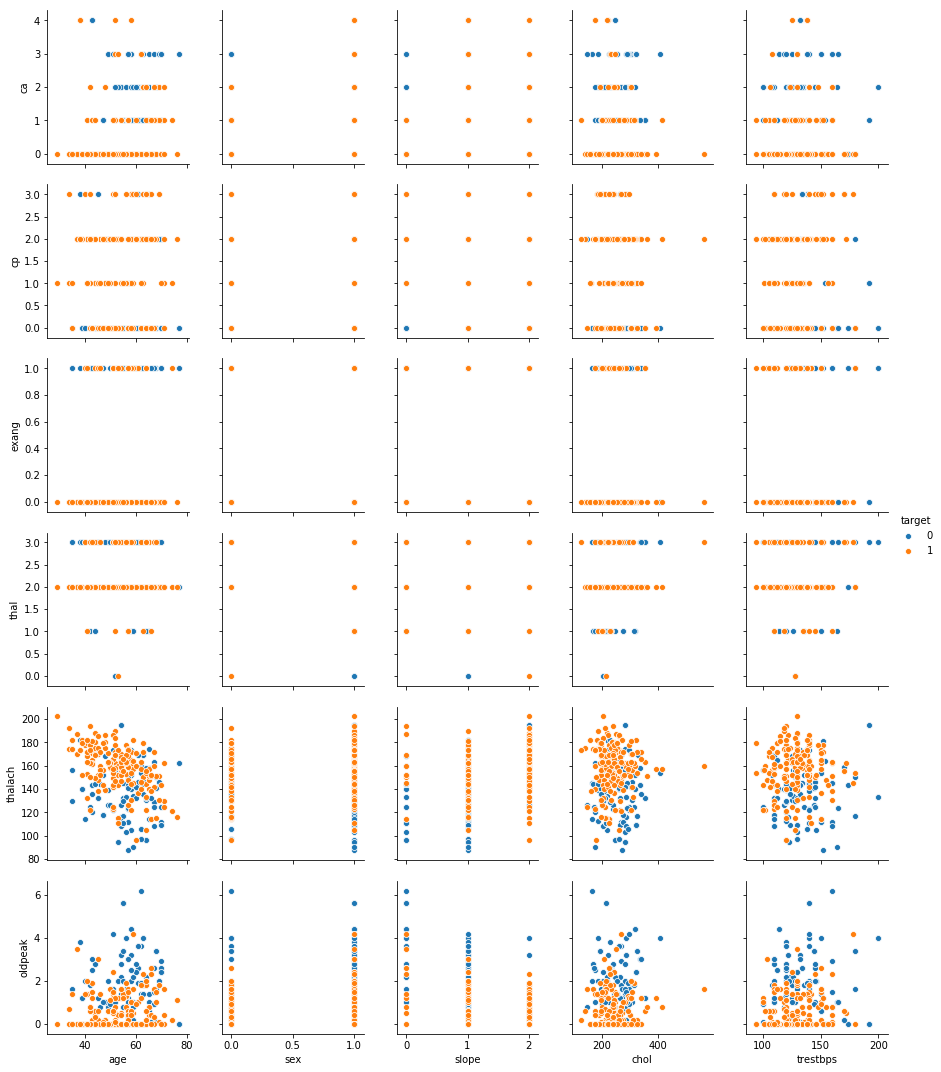

In [280]:
sns.pairplot(df_upsampled,hue='target',x_vars = 
            ['age','sex', 'slope','chol','trestbps'],
            y_vars = ['ca','cp','exang','thal','thalach','oldpeak'])

## More Iterations

### More Regression

In [281]:
from pyspark.ml.regression import LinearRegression

In [282]:
lr = LinearRegression(labelCol='target')

In [306]:
assembler_a = VectorAssembler(
    inputCols=["age"],
    outputCol="features")

In [307]:
output = assembler_a.transform(df1)

In [308]:
output.printSchema()

root
 |-- age: integer (nullable = true)
 |-- sex: integer (nullable = true)
 |-- cp: integer (nullable = true)
 |-- trestbps: integer (nullable = true)
 |-- chol: integer (nullable = true)
 |-- restecg: integer (nullable = true)
 |-- thalach: integer (nullable = true)
 |-- exang: integer (nullable = true)
 |-- oldpeak: double (nullable = true)
 |-- slope: integer (nullable = true)
 |-- ca: integer (nullable = true)
 |-- thal: integer (nullable = true)
 |-- target: integer (nullable = true)
 |-- features: vector (nullable = true)



In [310]:
# Let's select two columns (the feature and predictor).
# This is now in the appropriate format to be processed by Spark.
final_data = output.select('features','trestbps')
final_data.show()

+--------+--------+
|features|trestbps|
+--------+--------+
|  [63.0]|     145|
|  [37.0]|     130|
|  [41.0]|     130|
|  [56.0]|     120|
|  [57.0]|     120|
|  [57.0]|     140|
|  [56.0]|     140|
|  [44.0]|     120|
|  [52.0]|     172|
|  [57.0]|     150|
|  [54.0]|     140|
|  [48.0]|     130|
|  [49.0]|     130|
|  [64.0]|     110|
|  [58.0]|     150|
|  [50.0]|     120|
|  [58.0]|     120|
|  [66.0]|     150|
|  [43.0]|     150|
|  [69.0]|     140|
+--------+--------+
only showing top 20 rows



In [311]:
# Let's do a randomised 80/20 split. 
# Remember, you can use other splits depending on how easy/difficult it is to train your model.
train_data,test_data = final_data.randomSplit([0.8,0.2])

In [312]:
# Let's see our training data.
train_data.describe().show()

# And our testing data.
test_data.describe().show()

+-------+------------------+
|summary|          trestbps|
+-------+------------------+
|  count|               249|
|   mean|131.52208835341366|
| stddev| 17.61782094857456|
|    min|                94|
|    max|               200|
+-------+------------------+

+-------+------------------+
|summary|          trestbps|
+-------+------------------+
|  count|                54|
|   mean|132.09259259259258|
| stddev|  17.3208005812169|
|    min|               106|
|    max|               178|
+-------+------------------+



In [313]:
lr = LinearRegression(labelCol='trestbps')

In [314]:
# Fit the model to the data.
lrModel = lr.fit(train_data)

In [315]:
# Print the coefficients and intercept for linear regression.
print("Coefficients: {} Intercept: {}".format(lrModel.coefficients,lrModel.intercept))

Coefficients: [0.5668828256650382] Intercept: 100.86032973471191


In [316]:
# Let's evaluate the model against the test data.
test_results = lrModel.evaluate(test_data)

In [317]:
# Interesting results! This shows the difference between the predicted value and the test data.
test_results.residuals.show()

# Let's get some evaluation metrics (as discussed in the previous linear regression notebook).
print("RSME: {}".format(test_results.rootMeanSquaredError))

+-------------------+
|          residuals|
+-------------------+
| -2.134345807323214|
|-12.102525586978487|
| 10.897474413021513|
|  6.763708761691447|
| 24.763708761691447|
|-13.803174063973586|
| -5.803174063973586|
| -5.803174063973586|
|  3.629943110361367|
| -6.936939715303666|
|-18.070705366633746|
|-10.637588192298779|
| -8.637588192298779|
| -9.204471017963812|
| 14.795528982036188|
|-19.771353843628845|
| 10.228646156371155|
|-22.338236669293906|
| 41.661763330706094|
| 11.094880505041061|
+-------------------+
only showing top 20 rows

RSME: 16.91393264778552


In [318]:
# We can also get the R2 value. 
print("R2: {}".format(test_results.r2))

R2: 0.028436566943449204


In [320]:
final_data.describe().show()

+-------+------------------+
|summary|          trestbps|
+-------+------------------+
|  count|               303|
|   mean|131.62376237623764|
| stddev|  17.5381428135171|
|    min|                94|
|    max|               200|
+-------+------------------+

